In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import re
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [6]:
import io
from google.colab import files

trainTsv = files.upload()
tweets = pd.read_csv(io.BytesIO(trainTsv['Tweets.csv']))

Saving Tweets.csv to Tweets (2).csv


In [7]:

tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [8]:
print(tweets.columns)
df = pd.DataFrame({
    "sentiment":tweets.airline_sentiment,
    "text":tweets.text
})
print(f"Shape of our dataset >> {df.shape}")
df.head()

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')
Shape of our dataset >> (14640, 2)


,sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


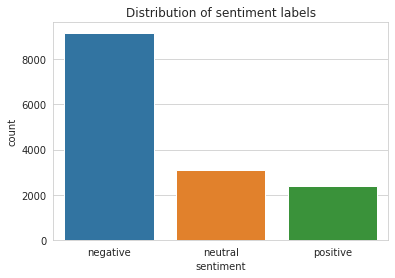

In [9]:
df.sentiment.replace(['negative','neutral','positive'],[-1,0,1],inplace=True)

sns.set_style("whitegrid")
sns.countplot(data=df,x='sentiment')
index = [0,1,2]
plt.xticks(index,['negative','neutral','positive'])
plt.title("Distribution of sentiment labels")
plt.show()

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stop_words = set(stopwords.words('english'))

shortword = re.compile(r"\b\w{1,2}\b")
url = re.compile(r"https?:*/+[a-zA-Z0-9./]*")

def clean(text):
    text = re.sub(url,'',text)
    text = re.sub(shortword,'',text)
    text = text.replace('@','')
    text = text.replace('#','')
    
    text = text.split()
    text = [word for word in text if word not in stop_words]
    text = " ".join(text)
    
    return text

df.text = df.text.apply(clean)
df.text[:15]

0                     VirginAmerica What dhepburn said.
1     VirginAmerica plus you' added commercials expe...
2     VirginAmerica didn' today... Must mean need ta...
3     VirginAmerica ' really aggressive blast obnoxi...
4                  VirginAmerica ' really big bad thing
5     VirginAmerica seriously would pay $ flight sea...
6     VirginAmerica yes, nearly every time fly “ear ...
7     VirginAmerica Really missed prime opportunity ...
8                virginamerica Well, didn'…but NOW ! :-
9     VirginAmerica amazing, arrived hour early. You...
10    VirginAmerica know suicide second leading caus...
11    VirginAmerica &; pretty graphics. much better ...
12    VirginAmerica This great deal! Already thinkin...
13    VirginAmerica virginmedia ' flying fabulous Se...
14                                VirginAmerica Thanks!
Name: text, dtype: object

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
print(f"{len(tokenizer.word_index)} words are used\n")

counts = tokenizer.word_counts
print(len(counts))

total_freq = 0
rare_freq = 0
rare_counts = 0
thread=2

for key,value in counts.items():
    total_freq += value
    if value<thread:
        rare_freq += value
        rare_counts += value

print(f"{rare_counts} are used less than {thread} times")
print(f"And these words accounts for {np.round(rare_freq/total_freq*100,2)}% of whole texts")

14088 words are used

14088
7772 are used less than 2 times
And these words accounts for 5.04% of whole texts


In [13]:
print("Tokenize only 7000 words.\nOther words are considered OOV")
word_size=7000
vocab_size = word_size+1
tokenizer = Tokenizer(num_words=word_size)

tokenizer.fit_on_texts(df.text)
tokenized = tokenizer.texts_to_sequences(df.text)

print("\nSamples\n")
print(tokenized[0])
print(tokenized[1])
print(len(tokenized))

Tokenize only 7000 words.
Other words are considered OOV

Samples

[30, 106, 6317, 143]
[30, 450, 85, 1022, 2339, 120, 6318]
14640


Average length of each row >> 10.0448087431694
Maximum length of each row >> 22


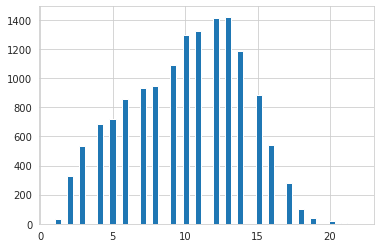

Pad all sequences into size of 20
(14640, 20)
Padded samples
[  30  106 6317  143    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
[  30  450   85 1022 2339  120 6318    0    0    0    0    0    0    0
    0    0    0    0    0    0]


In [14]:
lengths = [len(s) for s in tokenized]
print(f"Average length of each row >> {np.mean(lengths)}")
print(f"Maximum length of each row >> {np.max(lengths)}")

plt.hist(lengths,bins=50)
plt.show()

sequence_size = 20
print(f"Pad all sequences into size of {sequence_size}")

padded = pad_sequences(tokenized,maxlen=sequence_size,padding='post',truncating='post')
print(padded.shape)
print("Padded samples")
print(padded[0])
print(padded[1])

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
data = padded
label = to_categorical(df.sentiment,num_classes=3)

print("shape of data >>",data.shape)
print("shape of label >>",label.shape)

print("\nSamples of label data")
print(label[0])
print(label[1])

shape of data >> (14640, 20)
shape of label >> (14640, 3)

Samples of label data
[1. 0. 0.]
[0. 1. 0.]


shape of train data >> (10248, 20)
shape of test data >> (4392, 20)


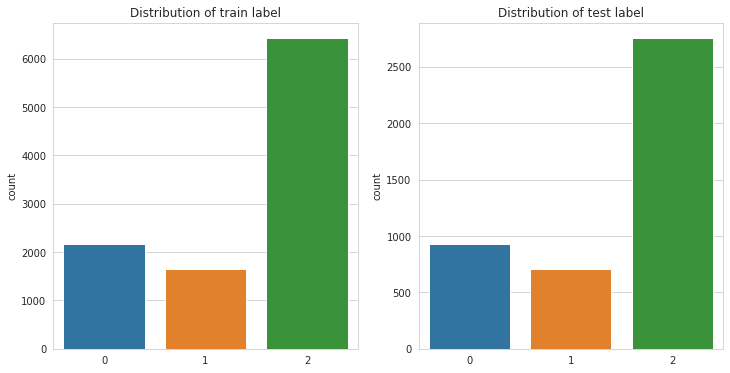

In [17]:
train_data,test_data,train_label,test_label = train_test_split(data,label,test_size=0.3,stratify=label,random_state=42)

print("shape of train data >>",train_data.shape)
print("shape of test data >>",test_data.shape)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
sns.countplot(x=np.argmax(train_label,axis=1))
plt.title("Distribution of train label")

ax2 = fig.add_subplot(1,2,2)
sns.countplot(x=np.argmax(test_label,axis=1))
plt.title("Distribution of test label")
plt.show()

index_to_sentiment = {
    0:'neutral',
    1:'positive',
    -1:'negative'
}

In [18]:
import os

!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-12-16 14:11:27--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-12-16 14:11:27--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-12-16 14:11:28--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
embedding_dict=dict()

f = open(os.path.join('glove.6B.100d.txt'),encoding='utf-8')
for line in f:
    tokens = line.split()
    word = tokens[0]
    word_vector = np.asarray(tokens[1:],dtype='float32')
    embedding_dict[word] = word_vector

f.close()

print(f"There are {len(embedding_dict)} embedding vectors in total")
print(f"Dimension of each vector >> {len(embedding_dict['read'])}")
embedding_size = len(embedding_dict['read'])


embedding_matrix = np.zeros((vocab_size,embedding_size))

for word,idx in tokenizer.word_index.items():
    if idx <= 7000:
        vector = embedding_dict.get(word)
        if vector is not None:
          embedding_matrix[idx] = np.asarray(vector,dtype='float32')

There are 400000 embedding vectors in total
Dimension of each vector >> 100


In [20]:
from keras.layers import Input,Embedding,TimeDistributed,Bidirectional,LSTM,BatchNormalization,Dense,GlobalMaxPool1D,GlobalAveragePooling1D,Dropout,Masking
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

word_vec_size=100
hidden_size=128

def create_lstm():
    X = Input(shape=[sequence_size])
    H = Embedding(vocab_size,word_vec_size,input_length=sequence_size,weights=[embedding_matrix],trainable=False)(X)
    H = Masking(mask_value=0.0)(H)

    H = Bidirectional(LSTM(hidden_size,return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    H = Bidirectional(LSTM(int(hidden_size/2),return_sequences=True))(H)
    
    H = GlobalMaxPool1D()(H)
    H = BatchNormalization()(H)
    H = Dense(32,activation='relu')(H)
    H = BatchNormalization()(H)
    Y = Dense(3,activation='softmax')(H)
    
    model = keras.models.Model(X,Y)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

es = EarlyStopping(monitor='val_accuracy',mode='min',patience=4,verbose=1)
rl = ReduceLROnPlateau(monitor='val_loss',mode='min',patience=3,verbose=1)

In [21]:
lstm_model = create_lstm()
lstm_history = lstm_model.fit(train_data,train_label,epochs=10,batch_size=64,validation_split=0.2,callbacks=[rl])
lstm_model.evaluate(test_data,test_label)

Epoch 1/10
129/129 [==============================] - 62s 289ms/step - loss: 0.7856 - accuracy: 0.6760 - val_loss: 0.8238 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 2/10
129/129 [==============================] - 29s 223ms/step - loss: 0.6147 - accuracy: 0.7520 - val_loss: 0.8652 - val_accuracy: 0.6195 - lr: 0.0010
Epoch 3/10
129/129 [==============================] - 29s 223ms/step - loss: 0.5695 - accuracy: 0.7627 - val_loss: 0.7304 - val_accuracy: 0.6976 - lr: 0.0010
Epoch 4/10
129/129 [==============================] - 29s 223ms/step - loss: 0.5188 - accuracy: 0.7918 - val_loss: 0.6609 - val_accuracy: 0.7234 - lr: 0.0010
Epoch 5/10
129/129 [==============================] - 29s 223ms/step - loss: 0.4960 - accuracy: 0.7992 - val_loss: 0.5869 - val_accuracy: 0.7659 - lr: 0.0010
Epoch 6/10
129/129 [==============================] - 29s 226ms/step - loss: 0.4618 - accuracy: 0.8125 - val_loss: 0.6206 - val_accuracy: 0.7693 - lr: 0.0010
Epoch 7/10
129/129 [==============================] 

[0.621636688709259, 0.7650273442268372]